# Setup

In [1]:
import copy
import json
import os
import shutil

import numpy as np
import palettable

In [2]:
from boilerplate_builder import BoilerplateBuilder

In [3]:
scene_dir_from_nb_dir = "../../scenes"
scene_dir_from_exec_dir = "../../scenes"

In [4]:
shutil.rmtree(scene_dir_from_nb_dir, ignore_errors=True)
os.makedirs(scene_dir_from_nb_dir)

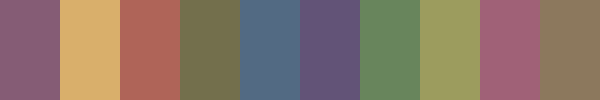

In [5]:
color_scheme = palettable.cartocolors.qualitative.Antique_10
colors = (np.array(color_scheme.mpl_colors) * 255).astype(int)
colors = np.hstack([colors, np.full((colors.shape[0], 1), 255)])
color_scheme.show_discrete_image()

In [6]:
bb = BoilerplateBuilder()

In [7]:
# Load the components_by_file json for validation
with open("components_by_file.json") as f:
    components_by_file = json.load(f)

# Main Scene

In [8]:
scene_key = "main_scene"
scene_data = {}

In [9]:
scene_key_i = "player"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
        "emplace_after_loading": True,
        "emplace_order": -1,
    }
}

In [10]:
scene_key_i = "enemies"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
    }
}

In [11]:
scene_key_i = "environment"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
        "emplace_after_loading": True,
    }
}

In [12]:
scene_key_i = "projectiles"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
    }
}

In [13]:
scene_key_i = "user_interface"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
        "emplace_after_loading": True,
        "emplace_order": 0,
    }
}

In [14]:
scene_key_i = "defeat_menu"
scene_data[scene_key_i] = {
    "SceneComp": {
        "scene_fp": f"{scene_dir_from_exec_dir}/{scene_key_i}.json",
    }
}

In [15]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

# Player

In [16]:
scene_key = "player"
scene_data = {}

In [17]:
scene_data["player"] = {
    "PhysicsComp": {},
    "DragForceComp": {"drag_coefficient": 0.05, "drag_power": 2.5},
    "DurabilityComp": {"max_durability": 100., "delete_at_zero": False, "durability_regen_rate": 0.1},
    "RenderFlag": {},
    "CircleComp": {"radius": 1.0, "fill_color": colors[2].tolist()},
    "ZOrderComp": {"zorder": 0},
    "PlayerFlag": {},
    "ViewFlag": {},
    # DEBUG
    "DebugComp": {},
}

In [18]:
# On player death, create a defeat menu
scene_data["player_durability_trigger"] = {
    "DurabilityTriggerFlag": {},
    "PairComp": {
        "source_entity_name": "player",
        "target_entity_name": "[SceneComp|name:defeat_menu]",
    },
}

In [19]:
scene_data["beacon"] = {
    "PhysicsComp": {},
    "MouseButtonReleasedComp": {},
    "RenderFlag": {},
    "CircleComp": {
        "radius": 0.5,
        "outline_thickness": 0.1,
        "fill_color": [0, 0, 0, 255],
        "outline_color": [255, 255, 255, 255],
    },
    "ZOrderComp": {"zorder": 1},
}

In [20]:
scene_data["player-beacon force"] = {
    "PairComp": {"target_entity_name": "player", "source_entity_name": "beacon"},
    "PairwiseForceComp": {"magnitude": -2.0},
}

In [21]:
# Watch that spawns a scene
scene_data["player_projectile_watch"] = {
    "WatchComp": {},
}
scene_data["player_projectile_watch_trigger"] = {
    "WatchTriggerFlag": {},
    "PairComp": {
        "source_entity_name": "player_projectile_watch",
        "target_entity_name": "[SceneComp|name:projectiles]",
    },
}

In [22]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameFlag to 'player_durability_trigger'
Adding UnresolvedNameFlag to 'player-beacon force'
Adding UnresolvedNameFlag to 'player_projectile_watch_trigger'


# Environment

In [23]:
scene_key = "environment"
scene_data = {}

In [24]:
# Background
n_bkgrd = 100
r_max = 1000.0
for i in range(n_bkgrd):
    scene_data[f"bkgrd.{i:03d}"] = {
        "PhysicsComp": {},
        "RenderFlag": {},
        "CircleComp": {
            "radius": int(r_max / (i + 1)),
            "outline_thickness": 0.0,
            "fill_color": [*colors[5][:3].tolist(), int(np.floor(255/n_bkgrd))],
            "outline_color": [63, 63, 63, 255],
        },
        "ZOrderComp": {"zorder": -i - 100},
    }

In [25]:
scene_data["enemy_spawn_trigger"] = {
    "EnemyAbsenceTriggerFlag": {},
    "PairComp": {
        "source_entity_name": "enemy_spawner",
        "target_entity_name": "[SceneComp|name:enemies]",
    },
}

In [26]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameFlag to 'enemy_spawn_trigger'


# Enemies

In [27]:
scene_key = "enemies"
scene_data = {}

In [28]:
n_enemies = 10
rng = np.random.default_rng()
xs = rng.uniform(-100, 100, n_enemies)
ys = rng.uniform(-120, -20, n_enemies)
for i in range(n_enemies):
    # Enemies themselves
    scene_data[f"enemy.{i:03d}"] = {
        "EnemyFlag": {},
        "PhysicsComp": {
            "pos": [xs[i], ys[i]],
            "vel": [0.0, 0.0],
        },
        "DragForceComp": {},
        "DurabilityComp": {
            "max_durability": 100.,
        },
        "RenderFlag": {},
        "CircleComp": {
            "radius": 1.0,
            "fill_color": colors[3].tolist(),
        },
        "ZOrderComp": {"zorder": 1},
    }

    # Relationships between enemies and player
    scene_data[f"enemy-player.{i:03d} inverse square"] = {
        "PairComp": {
            "source_entity_name": "[PlayerFlag|first]",
            "target_entity_name": f"enemy.{i:03d}",
        },
        "PairwiseForceComp": {
            "magnitude": -1.0,
            "power": -2.0,
            "softening": 1.0,
            "distance_scaling": 1.0,
        },
    }
    scene_data[f"enemy-player.{i:03d} spring"] = {
        "PairComp": {
            "source_entity_name": "[PlayerFlag|first]",
            "target_entity_name": f"enemy.{i:03d}",
        },
        "PairwiseForceComp": {
            "magnitude": -1.0,
        },
    }
    scene_data[f"enemy-player.{i:03d} collision"] = {
        "PairComp": {
            "source_entity_name": "[PlayerFlag|first]",
            "target_entity_name": f"enemy.{i:03d}",
        },
        "CollisionComp": {},
    }

In [29]:
# Enemy-enemy collisions
for i in range(n_enemies):
    for j in range(n_enemies):
        if i >= j:
            continue
        scene_data[f"enemy.{i:03d}-enemy.{j:03d} collision"] = {
            "PairComp": {
                "source_entity_name": f"enemy.{i:03d}",
                "target_entity_name": f"enemy.{j:03d}",
            },
            "CollisionComp": {},
        }

In [30]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameFlag to 'enemy-player.000 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.000 spring'
Adding UnresolvedNameFlag to 'enemy-player.000 collision'
Adding UnresolvedNameFlag to 'enemy-player.001 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.001 spring'
Adding UnresolvedNameFlag to 'enemy-player.001 collision'
Adding UnresolvedNameFlag to 'enemy-player.002 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.002 spring'
Adding UnresolvedNameFlag to 'enemy-player.002 collision'
Adding UnresolvedNameFlag to 'enemy-player.003 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.003 spring'
Adding UnresolvedNameFlag to 'enemy-player.003 collision'
Adding UnresolvedNameFlag to 'enemy-player.004 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.004 spring'
Adding UnresolvedNameFlag to 'enemy-player.004 collision'
Adding UnresolvedNameFlag to 'enemy-player.005 inverse square'
Adding UnresolvedNameFlag to 'enemy-player.005 spring'
Ad

# Projectiles

In [31]:
scene_key = "projectiles"
scene_data = {}

In [32]:
scene_data["projectile"] = {
    "PhysicsComp": {},
    "DragForceComp": {},
    "DurabilityComp": {},
    "RenderFlag": {},
    "CircleComp": {
        "radius": 0.5,
        "fill_color": colors[4].tolist(),
    },
    "ZOrderComp": {"zorder": -1},
}

In [33]:
scene_data["projectile-player sync"] = {
    "PairComp": {
        "target_entity_name": "projectile",
        "source_entity_name": "[PlayerFlag|first]",
    },
    "SyncPositionComp": {
        "once_only": True,
    },
}

In [34]:
scene_data["projectile-enemy force"] = {
    "PairComp": {
        "target_entity_name": "projectile",
        "source_entity_name": "[EnemyFlag|first]",
    },
    "PairwiseForceComp": {"magnitude": -10.0},
}

In [35]:
scene_data["projectile-enemy collisions"] = {
    "PairComp": {
        "source_entity_name": "projectile",
        "target_entity_name": "[EnemyFlag|first]",
    },
    "CollisionComp": {},
}

In [36]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameFlag to 'projectile-player sync'
Adding UnresolvedNameFlag to 'projectile-enemy force'
Adding UnresolvedNameFlag to 'projectile-enemy collisions'


# User Interface

In [37]:
scene_key = "user_interface"
scene_data = {}

In [38]:
scene_data["durability_bar"] = {
    "ValueBarComp": {"tracked_entity_name": "[PlayerFlag|first]"}
}

In [39]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)

Adding UnresolvedNameFlag to 'durability_bar'


# Defeat Menu

In [40]:
scene_key = "defeat_menu"
scene_data = {}

In [41]:
scene_data["defeat_text"] = {
    "TextComp": {
        "string": "Keep going?",
        "pos": [0.0, -25.0],
    },
}

In [42]:
scene_data["suspended_flag"] = {"SuspendedFlag": {}}

In [43]:
bb.save_scene_to_json(
    scene_key,
    scene_dir_from_nb_dir,
    scene_data,
    components_by_file["system_components"],
)